In [ ]:
import re
import gc
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import *
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from dataset import DisulfidEmbeddingDataset
from transformers import T5EncoderModel, T5Tokenizer
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score


DEVICE = "cuda:0"
PROTT5_PATH = "Rostlab/prot_t5_xl_uniref50"
MODEL_PATH = "./lightning_logs/all_res_model_with_noise_ft_50/all_res_model_with_noise_ft.pt"
CONFIG = dict(
    # Computation Resource
    gpu_id=[0],
    num_thread=16,
    loader_num_workers=16,
    loader_prefetch_factor=4,
    # For Training
    lr=5e-5,
    l2_lambda=0.1,
    batch_size=1,#6,
    random_seed=0,
    min_epochs=1,
    max_epochs=10,
    gradient_clip=1.0,
    lr_scheduler="LinearWarmup",
    # For Model
    d_model=128,
    d_ff=256,
    num_layers=2,
    num_heads=4,
    dropout_rate=0.1,
    is_decoder=False,
    use_cache=False,
    is_encoder_decoder=False,
    feed_forward_proj="gated-gelu",
)

In [123]:
config = T5Config(
    d_ff=CONFIG["d_ff"],
    d_model=CONFIG["d_model"],
    num_heads=CONFIG["num_heads"],
    num_layers=CONFIG["num_layers"],
    dropout_rate=CONFIG["dropout_rate"],
    is_decoder = False,
    use_cache = False,
    is_encoder_decoder = False,
)
model = DisulfidModel(
    config,
    learning_rate=CONFIG["lr"],
    epochs=CONFIG["max_epochs"],
    l2_lambda=CONFIG["l2_lambda"],
    lr_scheduler=CONFIG["lr_scheduler"],
    steps_per_epoch=0,
)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.eval().to(DEVICE)

In [ ]:
ds = DisulfidEmbeddingDataset("./data/testing")
data_loader = DataLoader(
    ds,
    shuffle=False,
    batch_size=CONFIG["batch_size"],
    num_workers=CONFIG["loader_num_workers"],
    prefetch_factor=CONFIG["loader_prefetch_factor"],
)

In [6]:
tokenizer = T5Tokenizer.from_pretrained(PROTT5_PATH, do_lower_case=False,)
emb_model = T5EncoderModel.from_pretrained(PROTT5_PATH)
emb_model = emb_model.to(DEVICE)
emb_model = emb_model.eval()
gc.collect()

/home/liangpu/miniforge3/envs/torch2.3/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


36

In [ ]:
def get_emb(seq):
    seq = [" ".join(seq)]
    seq = [re.sub(r"[UZOB]", "X", sequence) for sequence in seq]
    ids = tokenizer.batch_encode_plus(seq, add_special_tokens=True, padding=True)
    input_ids = torch.tensor(ids['input_ids']).to(DEVICE)
    attention_mask = torch.tensor(ids['attention_mask']).to(DEVICE)
    with torch.no_grad():
        embedding = emb_model(input_ids=input_ids,attention_mask=attention_mask)
    embedding = embedding.last_hidden_state.cpu().numpy()
    seq_len = (attention_mask[0] == 1).sum()
    embedding = embedding[0][:seq_len-1]
    return embedding

In [ ]:

preds = []
pred_scores = []
trues = []

for batch in tqdm(data_loader):
    with torch.no_grad():
        embs = [get_emb(s).astype(np.float16) for s in batch["seq"]]
        embs = [
            F.pad(
                    torch.tensor(e, dtype=torch.float32),
                    (0, 0, 0, 1024 - e.shape[0]),
                )
            for e in embs
        ]
        embs = torch.stack(embs)
        # embs = batch["emb"]
        pred = model.forward(embs.to(DEVICE), batch["mask"].to(DEVICE))
        pred_score = torch.sigmoid(pred[batch["cys_mask"].bool()].view(-1))
        pred = (pred_score>0.5).bool()
        true = batch["disulfid_res"][batch["cys_mask"].bool()].bool()
        pred_scores.append(pred_score.cpu().numpy())
        preds.append(pred.cpu().numpy())
        trues.append(true.cpu().numpy())

pred_scores = np.concatenate(pred_scores)
preds = np.concatenate(preds)
trues = np.concatenate(trues)

confusion_matrix(trues, preds), accuracy_score(trues, preds), recall_score(trues, preds), precision_score(trues, preds), f1_score(trues, preds)

100%|██████████| 115/115 [53:37<00:00, 27.98s/it]


(array([[6217, 1754],
        [ 152, 5083]]),
 0.855671664394972,
 0.9709646609360076,
 0.7434547316074301,
 0.8421139827700463)

Text(0, 0.5, 'Precision')

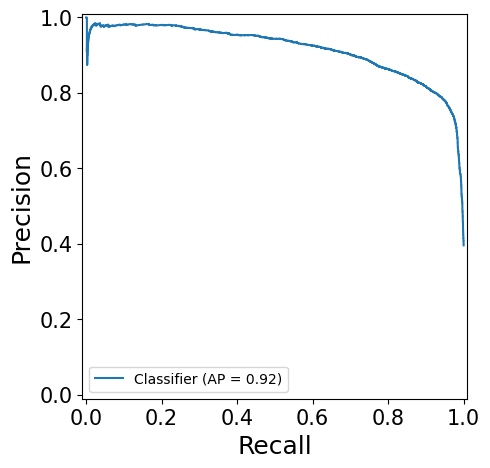

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
PrecisionRecallDisplay.from_predictions(trues, pred_scores, ax=ax)

ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

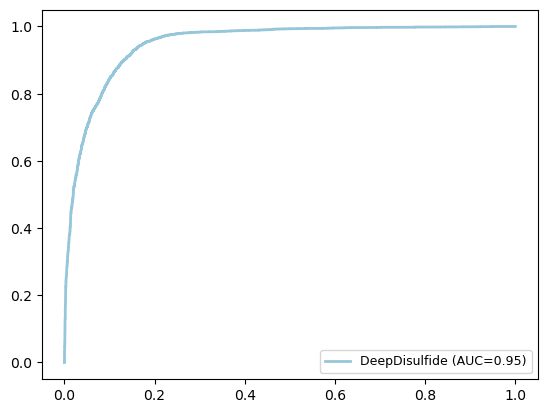

In [ ]:
our_tpr, our_fpr, threshold = roc_curve(trues, pred_scores)
roc_suc = roc_auc_score(trues, pred_scores)
plt.plot(our_tpr, our_fpr, label=f'DeepDisulfide (AUC={roc_suc:.2f})', linewidth=2, color="#96C6D9")
legend = plt.legend(fontsize=9)

In [ ]:
seq = "CNCKRFPQCPLNFLC"
emb = get_emb(seq)
emb = F.pad(
    torch.tensor(emb, dtype=torch.float32),
    (0, 0, 0, 1024 - emb.shape[0]),
).unsqueeze(0)

mask = torch.zeros(1024, dtype=torch.float32)
mask[:len(seq)] = 1
mask = mask.unsqueeze(0)
pred = model.forward(emb.to(DEVICE), mask.to(DEVICE))

(torch.sigmoid(pred[mask.bool()].view(-1))>0.5), torch.sigmoid(pred[mask.bool()].view(-1))

tensor(4, device='cuda:4') 4


(tensor([ True, False,  True, False, False, False, False, False,  True, False,
         False, False, False, False,  True], device='cuda:4'),
 tensor([9.9978e-01, 2.5345e-04, 9.9985e-01, 2.2168e-04, 5.8087e-04, 2.6370e-04,
         4.2629e-04, 5.3604e-04, 9.9981e-01, 2.7754e-04, 2.7818e-04, 2.1661e-04,
         2.2153e-04, 2.8626e-04, 9.9984e-01], device='cuda:4',
        grad_fn=<SigmoidBackward0>))